In [1]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
df = pd.read_csv('/content/Flipkart_Amazon Mobile Reviews.csv')
df.head()

,Unnamed: 0,Review-Title,rating,Review-Body,Product Name
0,0,Worst phone ever,1.0 out of 5 stars,Hang problem,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12..."
1,1,Ok !!! Not up to the mark,2.0 out of 5 stars,I'm writing this review after using 3days !!!B...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12..."
2,2,Awesome look,5.0 out of 5 stars,Camera is so good n very fast phone back look ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12..."
3,3,One plus losing is originality!!!,3.0 out of 5 stars,The media could not be loaded.\n ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12..."
4,4,Read,1.0 out of 5 stars,I got my delivery on 23 feb when I unboxed the...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12..."


Remove unnecessary columns & drop NAN from Review-Body.

In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.dropna(subset=['Review-Body'], axis=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23160 entries, 0 to 23776
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review-Title  23159 non-null  object
 1   rating        23160 non-null  object
 2   Review-Body   23160 non-null  object
 3   Product Name  23160 non-null  object
dtypes: object(4)
memory usage: 904.7+ KB


In [5]:
df['rating'].unique()

array(['1.0 out of 5 stars', '2.0 out of 5 stars', '5.0 out of 5 stars',
       '3.0 out of 5 stars', '4.0 out of 5 stars'], dtype=object)

As seen there are 5 unique ratings, now lets convert them into numbers & drop the original column.

In [6]:
df['rating_n'] = [int(i[:1]) for i in df['rating']]
df.drop('rating', axis=1, inplace=True)
df

,Review-Title,Review-Body,Product Name,rating_n
0,Worst phone ever,Hang problem,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1
1,Ok !!! Not up to the mark,I'm writing this review after using 3days !!!B...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",2
2,Awesome look,Camera is so good n very fast phone back look ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",5
3,One plus losing is originality!!!,The media could not be loaded.\n ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",3
4,Read,I got my delivery on 23 feb when I unboxed the...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1
...,...,...,...,...
23772,Batten in this rangee,Must he Bhai iss range me bas cemra thoda sa s...,"vivo iQOO Z6 5G (Chromatic Blue, 6GB RAM, 128G...",4
23773,Good mobile,Good product,"vivo iQOO Z6 5G (Chromatic Blue, 6GB RAM, 128G...",4
23774,Good camera,Good,"vivo iQOO Z6 5G (Chromatic Blue, 6GB RAM, 128G...",5
23775,Warest mobile,Don't buy this mobile phone money weast screen...,"vivo iQOO Z6 5G (Chromatic Blue, 6GB RAM, 128G...",1


In [7]:
df['Product Name'].unique()

array(['OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 128GB Storage)',
       'OPPO A31 (Mystery Black, 6GB RAM, 128GB Storage)',
       'realme narzo 50A (Oxygen Blue , 4GB RAM + 64 GB Storage)',
       'Redmi 10 Prime (Bifrost Blue 4GB RAM 64GB ROM ',
       'Redmi 9 Activ (Carbon Black, 4GB RAM, 64GB Storage)',
       'Redmi Note 11 (Space Black, 4GB RAM, 64GB Storage)',
       'Samsung Galaxy M32',
       'vivo iQOO Z6 5G (Chromatic Blue, 6GB RAM, 128GB Storage)'],
      dtype=object)

There are 8 unique products.

In [8]:
df_best_reviews = df.loc[(~df['Review-Body'].isna()) & (df['rating_n']==5)]
df_worst_reviews = df.loc[(~df['Review-Body'].isna()) & (df['rating_n']==1)]

def generate_wordcloud(text):
    """
    Generate word cloud images
    """
    wc = WordCloud(collocations=False, 
                   background_color="black",
                   max_words=200).generate(text)
    
    # set the figure size
    plt.figure(figsize=[8,10])

    # plot the wordcloud
    plt.imshow(wc, interpolation="bilinear")

    # remove plot axes
    plt.axis("off")

Lets plot wordcloud of 5 rated & 1 rated reviews.

Word cloud: 5-star reviews:


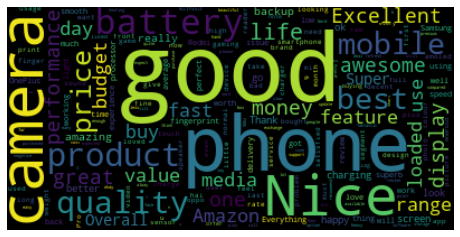

In [9]:
text_best_reviews = " ".join(df_best_reviews['Review-Body'])
print('Word cloud: 5-star reviews:')
generate_wordcloud(text_best_reviews)

Word cloud: 1-star reviews:


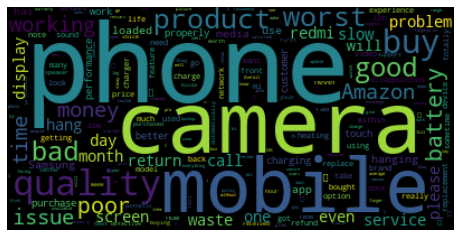

In [10]:
text_worst_reviews = " ".join(df_worst_reviews['Review-Body'])
print('Word cloud: 1-star reviews:')
generate_wordcloud(text_worst_reviews)

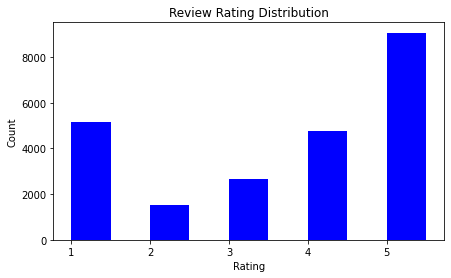

In [11]:
ax1 = df['rating_n'].plot(kind='hist', 
                          color='blue', 
                          grid=False, 
                          bins=[1,1.5,2,2.5,3,3.5,4,4.5,5,5.5], 
                          title='Review Rating Distribution',
                          figsize=(7,4))
ax1.set_xlabel("Rating")
ax1.set_ylabel("Count")
ax1.set_xticks([1,2,3,4,5], minor=False)

# set font size  
plt.rcParams['font.size'] = '10'

As seen from above chart, in this data we have more 5 star rated reviews, followed by 1 star & 4 star.

# Cleaning the Review-Body

In [12]:
df['Review-Body'] = df['Review-Body'].astype(str)
df['review'] = df['Review-Body'].str.lower()
df

,Review-Title,Review-Body,Product Name,rating_n,review
0,Worst phone ever,Hang problem,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1,hang problem
1,Ok !!! Not up to the mark,I'm writing this review after using 3days !!!B...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",2,i'm writing this review after using 3days !!!b...
2,Awesome look,Camera is so good n very fast phone back look ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",5,camera is so good n very fast phone back look ...
3,One plus losing is originality!!!,The media could not be loaded.\n ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",3,the media could not be loaded.\n ...
4,Read,I got my delivery on 23 feb when I unboxed the...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1,i got my delivery on 23 feb when i unboxed the...
...,...,...,...,...,...
23772,Batten in this rangee,Must he Bhai iss range me bas cemra thoda sa s...,"vivo iQOO Z6 5G (Chromatic Blue, 6GB RAM, 128G...",4,must he bhai iss range me bas cemra thoda sa s...
23773,Good mobile,Good product,"vivo iQOO Z6 5G (Chromatic Blue, 6GB RAM, 128G...",4,good product
23774,Good camera,Good,"vivo iQOO Z6 5G (Chromatic Blue, 6GB RAM, 128G...",5,good
23775,Warest mobile,Don't buy this mobile phone money weast screen...,"vivo iQOO Z6 5G (Chromatic Blue, 6GB RAM, 128G...",1,don't buy this mobile phone money weast screen...


In [13]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

df['review'] = df['review'].apply(lambda text: remove_urls(text))
df.head()

,Review-Title,Review-Body,Product Name,rating_n,review
0,Worst phone ever,Hang problem,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1,hang problem
1,Ok !!! Not up to the mark,I'm writing this review after using 3days !!!B...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",2,i'm writing this review after using 3days !!!b...
2,Awesome look,Camera is so good n very fast phone back look ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",5,camera is so good n very fast phone back look ...
3,One plus losing is originality!!!,The media could not be loaded.\n ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",3,the media could not be loaded.\n ...
4,Read,I got my delivery on 23 feb when I unboxed the...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1,i got my delivery on 23 feb when i unboxed the...


In [14]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df['review_wo_punct'] = df['review'].apply(lambda text: remove_punctuation(text))
df.head()

,Review-Title,Review-Body,Product Name,rating_n,review,review_wo_punct
0,Worst phone ever,Hang problem,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1,hang problem,hang problem
1,Ok !!! Not up to the mark,I'm writing this review after using 3days !!!B...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",2,i'm writing this review after using 3days !!!b...,im writing this review after using 3days be to...
2,Awesome look,Camera is so good n very fast phone back look ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",5,camera is so good n very fast phone back look ...,camera is so good n very fast phone back look ...
3,One plus losing is originality!!!,The media could not be loaded.\n ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",3,the media could not be loaded.\n ...,the media could not be loaded\n ...
4,Read,I got my delivery on 23 feb when I unboxed the...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1,i got my delivery on 23 feb when i unboxed the...,i got my delivery on 23 feb when i unboxed the...


In [15]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [16]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df['review_wo_stop'] = df['review_wo_punct'].apply(lambda text: remove_stopwords(text))
df.head()

,Review-Title,Review-Body,Product Name,rating_n,review,review_wo_punct,review_wo_stop
0,Worst phone ever,Hang problem,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1,hang problem,hang problem,hang problem
1,Ok !!! Not up to the mark,I'm writing this review after using 3days !!!B...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",2,i'm writing this review after using 3days !!!b...,im writing this review after using 3days be to...,im writing review using 3days honest normal an...
2,Awesome look,Camera is so good n very fast phone back look ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",5,camera is so good n very fast phone back look ...,camera is so good n very fast phone back look ...,camera good n fast phone back look awesomewith...
3,One plus losing is originality!!!,The media could not be loaded.\n ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",3,the media could not be loaded.\n ...,the media could not be loaded\n ...,media could loaded it’s average product decent...
4,Read,I got my delivery on 23 feb when I unboxed the...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1,i got my delivery on 23 feb when i unboxed the...,i got my delivery on 23 feb when i unboxed the...,got delivery 23 feb unboxed phone display dama...


In [17]:
cnt = Counter()
for text in df['review_wo_stop'].values:
    for word in text.split():
        cnt[word] += 1

cnt.most_common(20)

[('good', 9836),
 ('phone', 8527),
 ('camera', 6128),
 ('quality', 4335),
 ('battery', 3457),
 ('mobile', 3096),
 ('product', 2743),
 ('nice', 2144),
 ('price', 1912),
 ('buy', 1785),
 ('like', 1781),
 ('dont', 1484),
 ('bad', 1464),
 ('also', 1441),
 ('best', 1431),
 ('life', 1345),
 ('one', 1340),
 ('display', 1305),
 ('money', 1246),
 ('performance', 1107)]

In [18]:
# FREQWORDS = set([w for (w, wc) in cnt.most_common(20)])
# def remove_freqwords(text):
#     """custom function to remove the frequent words"""
#     return " ".join([word for word in str(text).split() if word not in FREQWORDS])

# df['review_wo_stopfreq'] = df['review_wo_stop'].apply(lambda text: remove_freqwords(text))
# df.head()

In [19]:
df['review_wo_stop'] = df['review_wo_stop'].str.replace('\d+', '')
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


,Review-Title,Review-Body,Product Name,rating_n,review,review_wo_punct,review_wo_stop
0,Worst phone ever,Hang problem,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1,hang problem,hang problem,hang problem
1,Ok !!! Not up to the mark,I'm writing this review after using 3days !!!B...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",2,i'm writing this review after using 3days !!!b...,im writing this review after using 3days be to...,im writing review using days honest normal and...
2,Awesome look,Camera is so good n very fast phone back look ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",5,camera is so good n very fast phone back look ...,camera is so good n very fast phone back look ...,camera good n fast phone back look awesomewith...
3,One plus losing is originality!!!,The media could not be loaded.\n ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",3,the media could not be loaded.\n ...,the media could not be loaded\n ...,media could loaded it’s average product decent...
4,Read,I got my delivery on 23 feb when I unboxed the...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1,i got my delivery on 23 feb when i unboxed the...,i got my delivery on 23 feb when i unboxed the...,got delivery feb unboxed phone display damage...


In [20]:
df.drop(['Review-Body','review','review_wo_punct'], axis=1, inplace=True)
df.head()

,Review-Title,Product Name,rating_n,review_wo_stop
0,Worst phone ever,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1,hang problem
1,Ok !!! Not up to the mark,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",2,im writing review using days honest normal and...
2,Awesome look,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",5,camera good n fast phone back look awesomewith...
3,One plus losing is originality!!!,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",3,media could loaded it’s average product decent...
4,Read,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1,got delivery feb unboxed phone display damage...


In [21]:
# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

Y = df['review_wo_stop']
df['POS_tagged'] = Y.apply(token_stop_pos)
df.head()

,Review-Title,Product Name,rating_n,review_wo_stop,POS_tagged
0,Worst phone ever,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1,hang problem,"[(hang, n), (problem, n)]"
1,Ok !!! Not up to the mark,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",2,im writing review using days honest normal and...,"[(im, n), (writing, v), (review, n), (using, v..."
2,Awesome look,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",5,camera good n fast phone back look awesomewith...,"[(camera, n), (good, a), (n, n), (fast, v), (p..."
3,One plus losing is originality!!!,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",3,media could loaded it’s average product decent...,"[(media, n), (could, None), (loaded, v), (’, n..."
4,Read,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1,got delivery feb unboxed phone display damage...,"[(got, v), (delivery, n), (feb, n), (unboxed, ..."


In [22]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew
    
df['Lemma'] = df['POS_tagged'].apply(lemmatize)
df.head()

,Review-Title,Product Name,rating_n,review_wo_stop,POS_tagged,Lemma
0,Worst phone ever,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1,hang problem,"[(hang, n), (problem, n)]",hang problem
1,Ok !!! Not up to the mark,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",2,im writing review using days honest normal and...,"[(im, n), (writing, v), (review, n), (using, v...",im write review use day honest normal androi...
2,Awesome look,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",5,camera good n fast phone back look awesomewith...,"[(camera, n), (good, a), (n, n), (fast, v), (p...",camera good n fast phone back look awesomewi...
3,One plus losing is originality!!!,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",3,media could loaded it’s average product decent...,"[(media, n), (could, None), (loaded, v), (’, n...",medium could load ’ average product decent d...
4,Read,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1,got delivery feb unboxed phone display damage...,"[(got, v), (delivery, n), (feb, n), (unboxed, ...",get delivery feb unboxed phone display damag...


# Using Vader for analysing sentiment of the cleaned reviews

In [23]:
sent_analyser = SentimentIntensityAnalyzer()

# function to calculate polarity
def getPolarity(text):
    return sent_analyser.polarity_scores(text)["compound"]

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [24]:
df['Polarity'] = df['Lemma'].apply(getPolarity)
df['Sentiment'] = df['Polarity'].apply(analysis)
df.drop(['POS_tagged','Lemma'], axis=1, inplace=True)
df.head()

,Review-Title,Product Name,rating_n,review_wo_stop,Polarity,Sentiment
0,Worst phone ever,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1,hang problem,-0.4019,Negative
1,Ok !!! Not up to the mark,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",2,im writing review using days honest normal and...,0.3818,Positive
2,Awesome look,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",5,camera good n fast phone back look awesomewith...,0.9774,Positive
3,One plus losing is originality!!!,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",3,media could loaded it’s average product decent...,0.9712,Positive
4,Read,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1,got delivery feb unboxed phone display damage...,0.4404,Positive


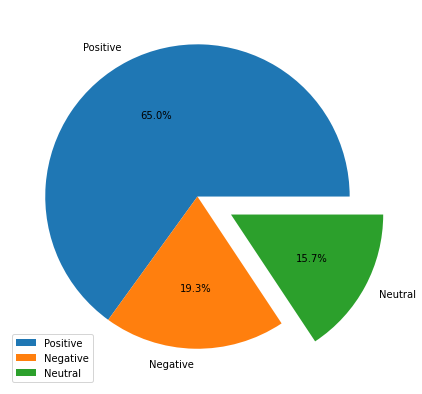

In [25]:
sent_counts = df['Sentiment'].value_counts()

plt.figure(figsize=(10,7))
plt.pie(sent_counts.values, labels=sent_counts.index, explode=(0,0,0.25), autopct='%1.1f%%', shadow=False)
plt.legend();

As seen from above chart, we see 65% Positive Sentiments, 19.3% Negative Sentiments & 15.7% Neutral Sentiments.

In [26]:
sent_counts

Positive    15060
Negative     4469
Neutral      3631
Name: Sentiment, dtype: int64

In [27]:
phone_df = df[['Product Name','Sentiment']]
phone_df

,Product Name,Sentiment
0,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",Negative
1,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",Positive
2,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",Positive
3,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",Positive
4,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",Positive
...,...,...
23772,"vivo iQOO Z6 5G (Chromatic Blue, 6GB RAM, 128G...",Neutral
23773,"vivo iQOO Z6 5G (Chromatic Blue, 6GB RAM, 128G...",Positive
23774,"vivo iQOO Z6 5G (Chromatic Blue, 6GB RAM, 128G...",Positive
23775,"vivo iQOO Z6 5G (Chromatic Blue, 6GB RAM, 128G...",Positive


In [35]:
phone_df.groupby(['Product Name','Sentiment'])['Sentiment'].count()

Product Name                                                Sentiment
OPPO A31 (Mystery Black, 6GB RAM, 128GB Storage)            Negative      590
                                                            Neutral       718
                                                            Positive     2966
OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 128GB Storage)  Negative      517
                                                            Neutral       571
                                                            Positive     2308
Redmi 10 Prime (Bifrost Blue 4GB RAM 64GB ROM               Negative      859
                                                            Neutral       675
                                                            Positive     2063
Redmi 9 Activ (Carbon Black, 4GB RAM, 64GB Storage)         Negative      926
                                                            Neutral       519
                                                            Positive    

From above groupby table, we see:

1. Positive Sentiments Top 3:

   a) Redmi 9 Activ (Carbon Black, 4GB RAM, 64GB Storage) - 3005
   
   b) OPPO A31 (Mystery Black, 6GB RAM, 128GB Storage) - 2966
   
   c) OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 128GB Storage) - 2308
   
   
2. Neutral Sentiments Top 3:

   a) OPPO A31 (Mystery Black, 6GB RAM, 128GB Storage) - 718
   
   b) Redmi 10 Prime (Bifrost Blue 4GB RAM 64GB ROM - 675
   
   c) OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 128GB Storage) - 571
   
   
3. Negative Sentiments Top 3:

   a) Redmi 9 Activ (Carbon Black, 4GB RAM, 64GB Storage) - 926
   
   b) Redmi 10 Prime (Bifrost Blue 4GB RAM 64GB ROM - 859
   
   c) Redmi Note 11 (Space Black, 4GB RAM, 64GB Storage) - 613

In [29]:
# df.to_csv('cleaned_data.csv', index=False)